# Imports and Function Definitions

In [236]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [9]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [239]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\

                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [91]:
# uso = pd.read_csv('C:\\Users\\nfischer\\Downloads\\USO.USUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
# spy = pd.read_csv('C:\\Users\\nfischer\\Downloads\\SPY.USUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
# vxx = pd.read_csv('C:\\Users\\nfischer\\Downloads\\VXX.USUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
fut = pd.read_csv('C:\\Users\\nfischer\\Downloads\\LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('C:\\Users\\nfischer\\Downloads\\GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
# xom = pd.read_csv('C:\\Users\\nfischer\\Downloads\\XOM.USUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('C:\\Users\\nfischer\\Downloads\\BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('C:\\Users\\nfischer\\Downloads\\USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [92]:
data_dict = {'fut':fut, 'gas':gas, #'uso':uso, 'spy':spy, 'vxx':vxx, 'xom':xom
            'btc':btc, 'bond':bond}

Datetime and indexing

In [93]:
idx = pd.to_datetime(data_dict['fut']['Local time'])

In [94]:
for data in data_dict.keys():
    data_dict[data] = data_dict[data].set_index(idx)
    data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)

Merging

In [97]:
df = pd.DataFrame(index=data_dict['fut'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data])
df = df.rename(columns={'Close':'Close_fut'})

In [115]:
df

,Close_fut,Close_gas,Close_btc,Close_bond
Local time,,,,
2020-01-03 00:00:00+06:00,45.256,1.6964,8469,170.092
2020-01-03 00:05:00+06:00,45.256,1.6964,8469,170.092
2020-01-03 00:10:00+06:00,45.256,1.6964,8469,170.092
2020-01-03 00:15:00+06:00,45.256,1.6964,8469,170.092
2020-01-03 00:20:00+06:00,45.256,1.6964,8469,170.092
...,...,...,...,...
2023-12-01 23:35:00+06:00,78.112,3.6598,18767,130.274
2023-12-01 23:40:00+06:00,78.217,3.6539,18775,130.276
2023-12-01 23:45:00+06:00,78.204,3.6609,18781,130.301


## maybe exclude all where diff(future)==0 to exclude weekends and closed times? might make data fucked though

## more likely just exclude to business days and hours

<AxesSubplot: >

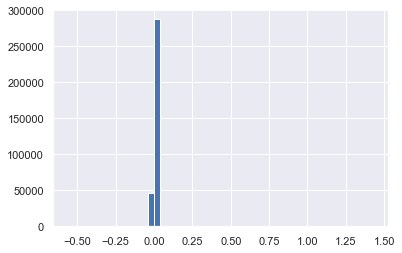

In [125]:
df['Close_fut'].pct_change().hist(bins=50)

In [129]:
rets = df['Close_fut'].pct_change()

## should exclude the points below

In [147]:
rets.loc[(rets>1) | (rets<-.5)]

Local time
2020-01-04 00:00:00+05:00   -0.556179
2020-02-04 00:00:00+05:00   -0.550320
2020-03-06 00:00:00+05:00    1.003725
2020-04-03 00:00:00+06:00    1.335824
2020-05-03 00:00:00+06:00    1.427124
Name: Close_fut, dtype: float64

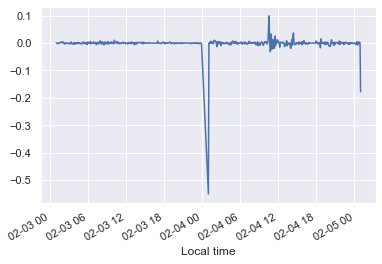

<AxesSubplot: xlabel='Local time'>

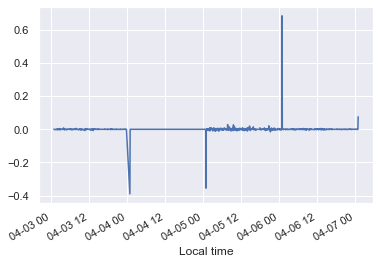

In [152]:

rets[pd.to_datetime('2020-02-03 00:00:00+05:00'):pd.to_datetime('2020-02-05 00:00:00+05:00')].plot()
plt.show()
rets[pd.to_datetime('2020-04-03 00:00:00+05:00'):pd.to_datetime('2020-04-07 00:00:00+05:00')].plot()

# Test Train Splits

Naive intraday test: split into 80-20 test train on a single day

EDIT 1: Need more data than above.  Will do 5 days:

In [206]:
DO 5 DAYS HERE

## Making Vol (Outcome)

Use historical $n$-period standard deviation.  We will use $n=6.5_{\text{trading hours}}*12_{\text{multiples of 5 minutes per hour}}=78$

In [220]:
n=78

In [221]:
day['fut_'+str(n)+'_std'] = day.rolling(n)['Close_fut'].std()

In [222]:
day[75:100]

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 14:15:00+05:00,-0.000300,0.000025,-0.002071,-0.000360,NaN
2021-09-08 14:20:00+05:00,0.000300,-0.000296,0.001189,0.000354,NaN
2021-09-08 14:25:00+05:00,0.000374,-0.000469,-0.000216,0.000397,0.002224
2021-09-08 14:30:00+05:00,-0.000075,-0.000592,-0.002829,-0.000385,0.002045
2021-09-08 14:35:00+05:00,0.000749,0.000049,-0.000043,0.000000,0.002023
2021-09-08 14:40:00+05:00,-0.001182,-0.003926,-0.000628,0.000000,0.001964
2021-09-08 14:45:00+05:00,0.000135,-0.000223,0.000433,-0.000214,0.001961
2021-09-08 14:50:00+05:00,0.000599,-0.000471,-0.007409,0.000006,0.001950
2021-09-08 14:55:00+05:00,-0.000898,0.000198,0.002772,-0.000568,0.001943


In [233]:
X = day.drop('fut_78_std', axis=1)[77:]
Y = day['fut_78_std'][77:]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Autocorrelation analysis

In [162]:
ret = df.pct_change(1)

In [175]:
ret.reset_index(drop=True)['Close_fut']

0              NaN
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
335731   -0.000090
335732    0.001344
335733   -0.000166
335734    0.000384
335735   -0.000831
Name: Close_fut, Length: 335736, dtype: float64

Close_fut


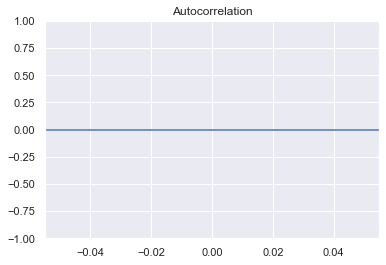

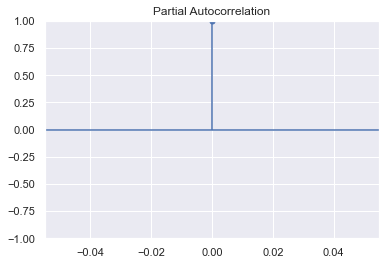

Close_gas


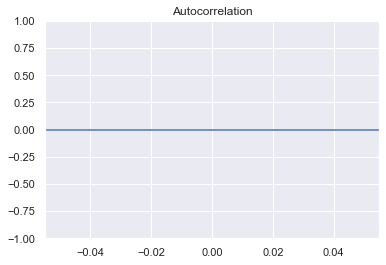

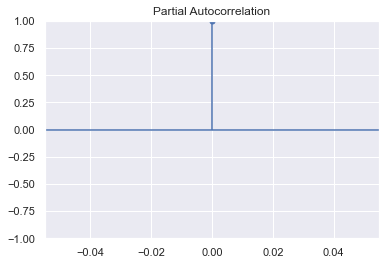

Close_btc


KeyboardInterrupt: 

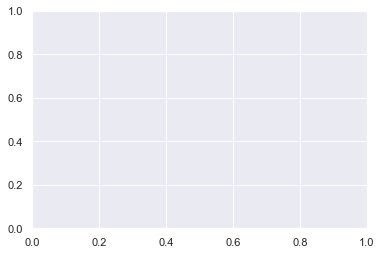

In [164]:
for feat in df.columns:
    print(feat)
    plot_acf(ret.reset_index(drop=True)[feat])
    plot_pacf(ret.reset_index(drop=True)[feat])
    plt.show()

## Initial Model testing

In [240]:
res = {'RF':None, 'GB':None}
for model in res.keys():
    r = model_selection(model)
    res[model] = r

RF
RandomForestRegressor(max_depth=10, n_estimators=10)
MAE:  0.00018930212901259263 
MSE:  4.002763584806203e-08 
RMSE:  0.00020006907769083666
GB
GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10)
MAE:  0.00020812947123731586 
MSE:  4.332753712585249e-08 
RMSE:  0.00020815267744098918


In [244]:
day[77:]

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 14:25:00+05:00,0.000374,-0.000469,-0.000216,0.000397,0.002224
2021-09-08 14:30:00+05:00,-0.000075,-0.000592,-0.002829,-0.000385,0.002045
2021-09-08 14:35:00+05:00,0.000749,0.000049,-0.000043,0.000000,0.002023
2021-09-08 14:40:00+05:00,-0.001182,-0.003926,-0.000628,0.000000,0.001964
2021-09-08 14:45:00+05:00,0.000135,-0.000223,0.000433,-0.000214,0.001961
2021-09-08 14:50:00+05:00,0.000599,-0.000471,-0.007409,0.000006,0.001950
2021-09-08 14:55:00+05:00,-0.000898,0.000198,0.002772,-0.000568,0.001943
2021-09-08 15:00:00+05:00,0.000225,0.000273,0.003286,-0.000177,0.001827
2021-09-08 15:05:00+05:00,0.000509,-0.000050,0.002386,-0.000208,0.001791


In [241]:
res

{'RF': (RandomForestRegressor(max_depth=10, n_estimators=10),
  array([0.00192517, 0.00181467, 0.00192394, 0.00177434])),
 'GB': (GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10),
  array([0.00187836, 0.00187836, 0.00187836, 0.00187836]))}